# hw4 - NN pyTorch

Во всем задании вы должны работать со входом из строк размером (длиной) 1024

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from scipy import signal

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Часть 1 Фурье

### Подготовка данных

Сгенерите данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [3]:
def generate_signals(n_signals, n_points):
    """Generates a set of signals with added noise."""
    try:
        x = np.linspace(0, 2 * np.pi, n_points)
        
        # Vectorized signal generation
        exp_freq = np.random.randint(0, 700, size=n_signals)
        sin_freq = np.random.randint(1, 512, size=n_signals)
        sin_phase = np.random.randint(0, 640, size=n_signals) / 100
        sincos_freq1 = np.random.randint(1, 700, size=n_signals)
        sincos_freq2 = np.random.randint(1, 800, size=n_signals)

        signals = np.empty((3 * n_signals, n_points), dtype=complex)
        signals[:n_signals] = np.exp(1j * x * exp_freq[:, np.newaxis])
        signals[n_signals:2*n_signals] = np.sin(x * sin_freq[:, np.newaxis] + sin_phase[:, np.newaxis])
        signals[2*n_signals:] = np.sin(x * sincos_freq1[:, np.newaxis]) + np.cos(x * sincos_freq2[:, np.newaxis])


        # Add noise
        noise = np.random.random((3 * n_signals, n_points)) / 10 + 1j * np.random.random((3 * n_signals, n_points)) * 0.1
        signals += noise

        return signals

    except ValueError as e:
        print(f"Error generating signals: {e}")
        return None

# Parameters
n_signals = 3000  # Number of signals (per signal type)
n_points = 512  # Points per signal

# Generate signals
signals = generate_signals(n_signals, n_points)

# FFT and data preparation
transformed_signals = np.fft.fft(signals)
signals = np.hstack([signals.real, signals.imag])
transformed_signals = np.hstack([transformed_signals.real, transformed_signals.imag])

# Train-test split and PyTorch conversion
X_train, X_test, y_train, y_test = train_test_split(signals, transformed_signals)

X_train = torch.tensor(X_train, device=device, requires_grad=True)
X_test = torch.tensor(X_test, device=device, requires_grad=True)
y_train = torch.tensor(y_train, device=device, requires_grad=True)
y_test = torch.tensor(y_test, device=device, requires_grad=True)

In [4]:
D_in = X_train.shape[1]
D_out = y_train.shape[1]

D_in, D_out

(1024, 1024)

In [5]:
X_train.shape

torch.Size([6750, 1024])

### Соберите и обучите нейросетку на pyTroch для преобразования Фурье

In [6]:
loss_fn = nn.MSELoss()

def batch_train(model, optimizer, x, y):
    model.zero_grad()
    
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    
    return (loss.item())

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.act1 = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(D_in, 800, dtype=torch.float64).to(device)
        self.bn1 = torch.nn.BatchNorm1d(800, dtype=torch.float64).to(device)
        self.fc2 = torch.nn.Linear(800, 600, dtype=torch.float64).to(device)
        self.bn2 = torch.nn.BatchNorm1d(600, dtype=torch.float64).to(device)
        self.fc3 = torch.nn.Linear(600, 600, dtype=torch.float64).to(device)
        self.bn3 = torch.nn.BatchNorm1d(600, dtype=torch.float64).to(device)
        self.fc4 = torch.nn.Linear(600, D_out, dtype=torch.float64).to(device)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act1(x)
        x = self.fc4(x)
        return x

In [7]:
model = Model()
model = model.apply(init_weights)
optimizerAdam = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 1000
batch_size = 3000

for epoch in tqdm(range(n_epochs)):

    permutation = torch.randperm(X_train.size()[0]).to(device)

    for i in range(0, X_train.float().size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        batch_train(model, optimizerAdam, batch_x, batch_y)

    if epoch % 100 == 0:
        y_train_pred = model(X_train)
        loss_train = loss_fn(y_train_pred, y_train)
        y_test_pred = model(X_test)
        loss_test = loss_fn(y_test_pred, y_test)
        print(loss_train.data, loss_test.data)

print(loss_train)

  0%|                                          | 1/1000 [00:01<17:07,  1.03s/it]

tensor(212.4259, dtype=torch.float64) tensor(213.4744, dtype=torch.float64)


 10%|████                                    | 101/1000 [01:20<13:18,  1.13it/s]

tensor(110.5244, dtype=torch.float64) tensor(127.5609, dtype=torch.float64)


 20%|████████                                | 201/1000 [02:43<12:18,  1.08it/s]

tensor(59.9663, dtype=torch.float64) tensor(88.0312, dtype=torch.float64)


 30%|████████████                            | 301/1000 [04:03<10:10,  1.15it/s]

tensor(41.3493, dtype=torch.float64) tensor(74.1798, dtype=torch.float64)


 40%|████████████████                        | 401/1000 [05:22<08:40,  1.15it/s]

tensor(33.5112, dtype=torch.float64) tensor(67.8154, dtype=torch.float64)


 50%|████████████████████                    | 501/1000 [06:41<07:19,  1.14it/s]

tensor(29.3893, dtype=torch.float64) tensor(64.0148, dtype=torch.float64)


 60%|████████████████████████                | 601/1000 [08:00<05:51,  1.14it/s]

tensor(26.9891, dtype=torch.float64) tensor(61.4961, dtype=torch.float64)


 70%|████████████████████████████            | 701/1000 [09:19<04:18,  1.16it/s]

tensor(25.4840, dtype=torch.float64) tensor(59.7557, dtype=torch.float64)


 80%|████████████████████████████████        | 801/1000 [10:38<02:56,  1.13it/s]

tensor(24.4479, dtype=torch.float64) tensor(58.3932, dtype=torch.float64)


 90%|████████████████████████████████████    | 901/1000 [11:58<01:27,  1.13it/s]

tensor(23.7277, dtype=torch.float64) tensor(57.3438, dtype=torch.float64)


100%|███████████████████████████████████████| 1000/1000 [13:17<00:00,  1.25it/s]

tensor(23.7277, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [8]:
model.eval()

Model(
  (act1): ReLU()
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=800, out_features=600, bias=True)
  (bn2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=600, out_features=600, bias=True)
  (bn3): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=600, out_features=1024, bias=True)
)

In [9]:
def compare(true, predicted):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[1].plot(true)
    axes[1].set_title('fft')
    axes[0].plot(predicted)
    axes[0].set_title('model predict')

def compare_f(model, f):
    x = np.linspace(0, 2 * np.pi, n_points)
    f_x = f(x)
    y_fft = np.fft.fft(f_x)
    y_fft = np.hstack([y_fft.real, y_fft.imag])

    f_t = torch.tensor([np.hstack([f_x.real, f_x.imag])]).to(device)
    model_fft = model(f_t)
    
    compare(y_fft, model_fft[0].cpu().detach())

In [10]:
prediction = model(X_test)
mse = loss_fn(prediction, y_test)
mse

tensor(55.2527, dtype=torch.float64, grad_fn=<MseLossBackward0>)

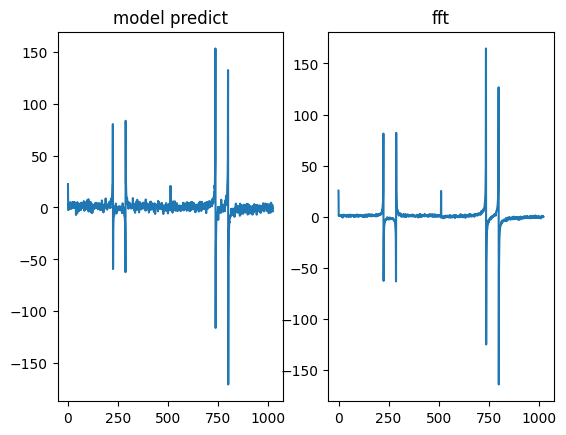

In [11]:
num = 114
compare(y_test[num].cpu().detach(), prediction[num].cpu().detach())

### Сравните свое решение с пакетным методом

/tmp/ipykernel_3031353/4209531846.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/torch/csrc/utils/tensor_new.cpp:278.)
  f_t = torch.tensor([np.hstack([f_x.real, f_x.imag])]).to(device)


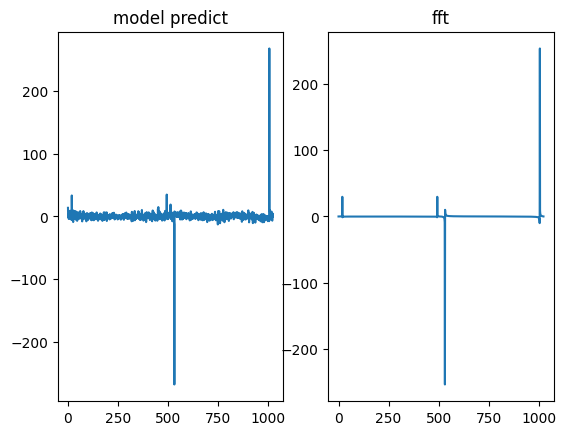

In [12]:
compare_f(model, lambda t: np.sin(530 * t))

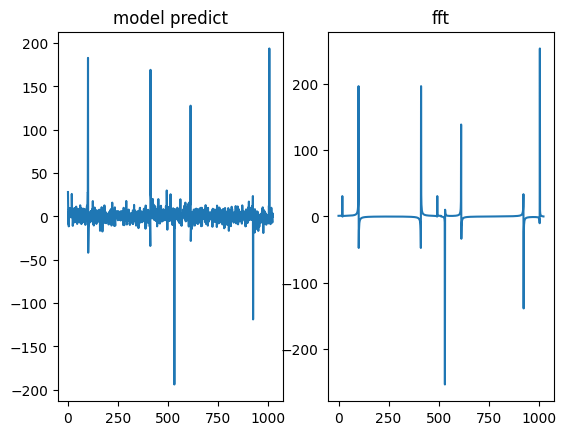

In [13]:
compare_f(model, lambda t: np.sin(530 * t) + np.cos(100 * t))

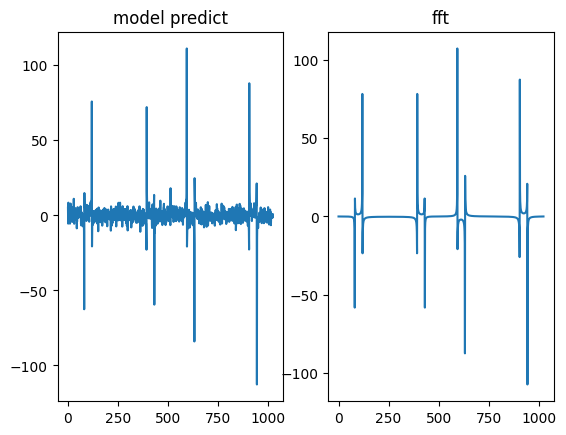

In [14]:
compare_f(model, lambda t: np.sin(530 * t) * np.cos(100 * t))

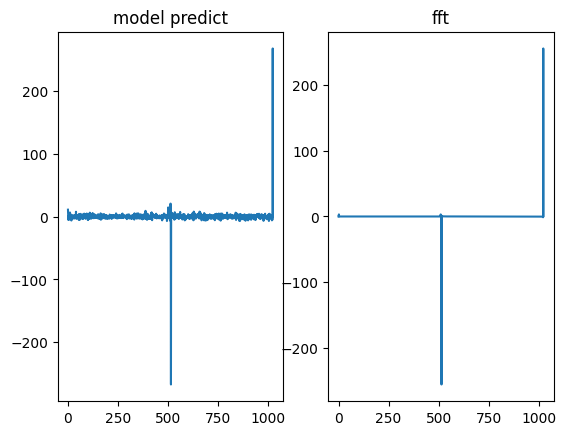

In [15]:
compare_f(model, lambda t: np.sin(2 * t))

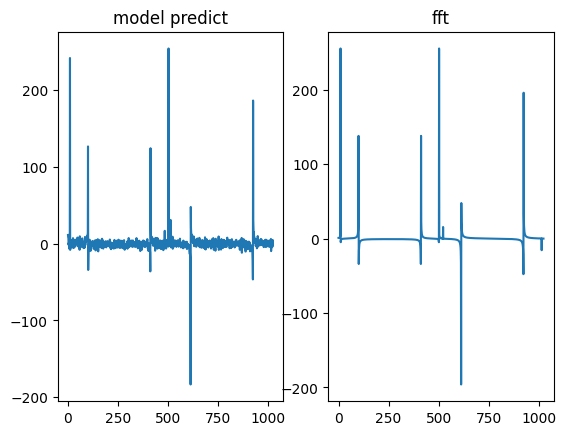

In [16]:
compare_f(model, lambda x: 1 * np.sin(100 * x) + np.cos(10 * x))

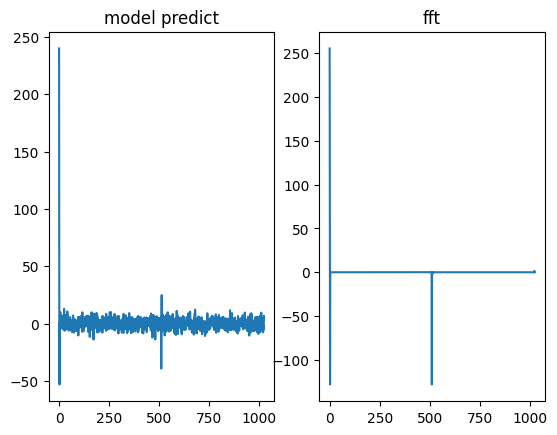

In [17]:
compare_f(model, lambda x: np.sin(x) ** 2)

## Часть 2 Power spectral density (dB)

### Подготовка данных

Используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html), подготовьте обучающую выборку.

In [18]:
def generate_samples(n):
    """Generates multiple signals with added noise efficiently."""
    rng = np.random.default_rng()
    fs = 100
    N = 1024
    noise_power = 0.001 * fs / 2
    time = np.arange(N) / fs

    # Vectorize parameter generation
    amps = np.random.randint(1, 10, size=n) * np.sqrt(np.random.randint(1, 10, size=n))
    freqs = np.random.randint(1, 102, size=n)
    func_indices = np.random.randint(0, 3, size=n)

    # Pre-allocate array for efficiency.
    samples = np.empty((n, N))

    # Vectorized signal generation
    funcs = [np.sin, np.cos, lambda x: np.sin(x) + np.cos(x)]
    for i, (amp, freq, func_index) in enumerate(zip(amps, freqs, func_indices)):
        samples[i] = amp * funcs[func_index](2 * np.pi * freq * time)


    # Add noise - vectorized
    samples += rng.normal(scale=np.sqrt(noise_power), size=samples.shape)
    return fs, samples

# Parameters
n = 6000

# Generate signals
fs, generated = generate_samples(n)

# Periodogram calculation
f, periodogram = signal.periodogram(generated, fs)


# Train-test split and PyTorch conversion
X_train, X_test, y_train, y_test = train_test_split(generated, periodogram, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, device=device, requires_grad=True)
X_test = torch.tensor(X_test, device=device, requires_grad=True)
y_train = torch.tensor(y_train, device=device, requires_grad=True)
y_test = torch.tensor(y_test, device=device, requires_grad=True)

In [19]:
D_in = X_train.shape[1]
D_out = y_train.shape[1]
D_in, D_out

(1024, 513)

In [20]:
X_test.shape

torch.Size([1200, 1024])

### Соберите и обучите нейросеть для предсказания спектральной плотности мощности

*Подсказка: для входа 1024 выход будет 512*

In [21]:
loss_fn = nn.MSELoss()

model = Model()
model = model.apply(init_weights)
optimizerAdam = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 500
batch_size = 2000

for epoch in tqdm(range(n_epochs)):

    permutation = torch.randperm(X_train.size()[0]).to(device)

    for i in range(0, X_train.float().size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        batch_train(model, optimizerAdam, batch_x, batch_y)

    if epoch % 100 == 0:
        y_train_pred = model(X_train)
        loss_train = loss_fn(y_train_pred, y_train)
        y_test_pred = model(X_test)
        loss_test = loss_fn(y_test_pred, y_test)
        print(loss_train, loss_test)

print(loss_train)

  0%|                                           | 1/500 [00:00<05:23,  1.54it/s]

tensor(3542.6843, dtype=torch.float64, grad_fn=<MseLossBackward0>) tensor(3813.3294, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 20%|████████▎                                | 101/500 [00:49<03:41,  1.80it/s]

tensor(2466.9776, dtype=torch.float64, grad_fn=<MseLossBackward0>) tensor(2711.6718, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 40%|████████████████▍                        | 201/500 [01:39<02:50,  1.76it/s]

tensor(1202.2267, dtype=torch.float64, grad_fn=<MseLossBackward0>) tensor(1393.2855, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 60%|████████████████████████▋                | 301/500 [02:31<01:52,  1.78it/s]

tensor(364.5885, dtype=torch.float64, grad_fn=<MseLossBackward0>) tensor(490.4479, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 80%|████████████████████████████████▉        | 401/500 [03:21<00:53,  1.84it/s]

tensor(63.2655, dtype=torch.float64, grad_fn=<MseLossBackward0>) tensor(140.9783, dtype=torch.float64, grad_fn=<MseLossBackward0>)


100%|█████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s]

tensor(63.2655, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [22]:
model.eval()

Model(
  (act1): ReLU()
  (fc1): Linear(in_features=1024, out_features=800, bias=True)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=800, out_features=600, bias=True)
  (bn2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=600, out_features=600, bias=True)
  (bn3): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=600, out_features=513, bias=True)
)

### Провалидируйте свое решение

*Примечание: Для сдачи достаточно качественного соответствия по форме спектра с пакетным решением*

In [23]:
def compare(true, predicted):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[1].plot(true)
    axes[1].set_title('scipy')
    axes[0].plot(predicted)
    axes[0].set_title('model predict')

In [24]:
def compare_log(true, predicted):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[1].semilogy(true)
    axes[1].set_title('scipy')
    axes[0].semilogy(predicted)
    axes[0].set_title('model predict')

In [25]:
test_pred = model(X_test)
mse_of_train = loss_fn(test_pred, y_test)
mse_of_train

tensor(28.2125, dtype=torch.float64, grad_fn=<MseLossBackward0>)

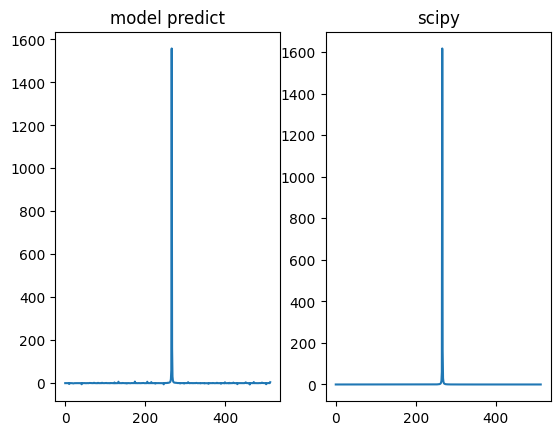

In [26]:
num = 37
compare(y_test[num].cpu().detach(), test_pred[num].cpu().detach())

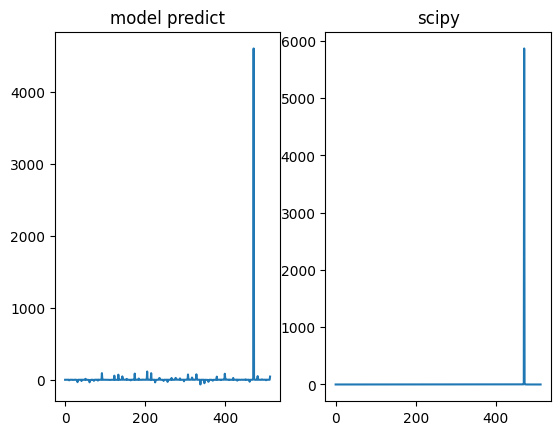

In [27]:
num = 30
compare(y_test[num].cpu().detach(), test_pred[num].cpu().detach())

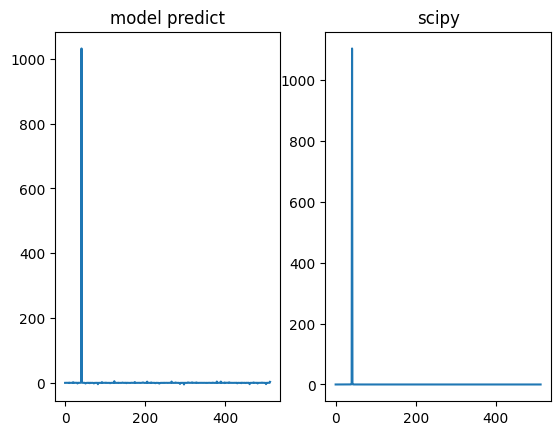

In [28]:
num = 307
compare(y_test[num].cpu().detach(), test_pred[num].cpu().detach())

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not

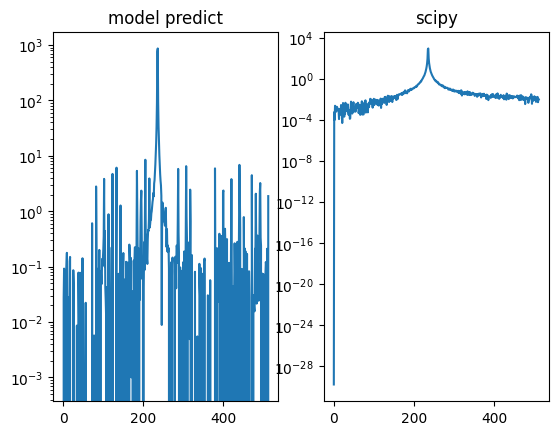

In [29]:
num = 102
compare_log(y_test[num].cpu().detach(), test_pred[num].cpu().detach())

In [30]:
def compare_f(model, fs, func):
    N = 1024
    time = np.arange(N) / fs
    freq = 1025
    f = func(2 * np.pi * freq * time)
    nu, pxx = signal.periodogram(f, fs)
    compare(pxx, model(torch.tensor([f]).to(device))[0].cpu().detach())

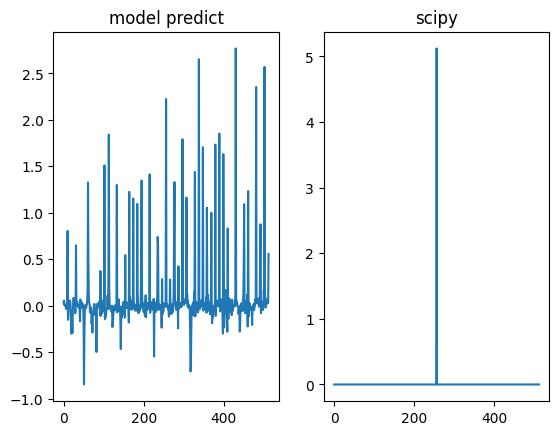

In [31]:
compare_f(model, fs, np.sin)

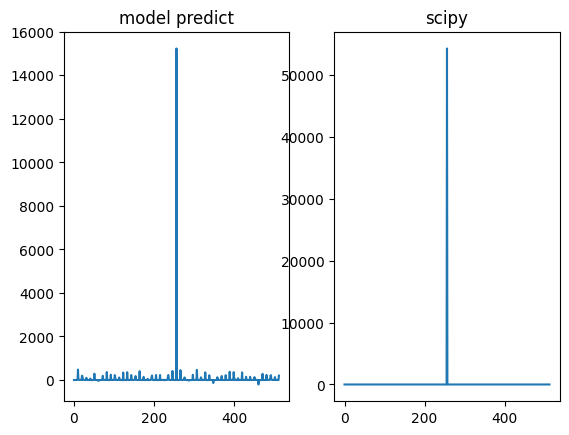

In [32]:
compare_f(model, fs, lambda x: 103 * np.sin(1 * x))

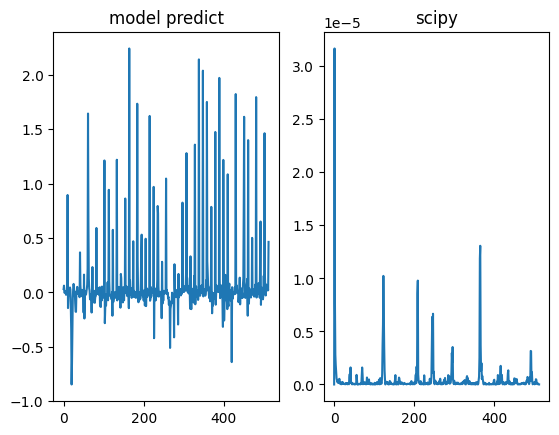

In [33]:
compare_f(model, fs, lambda t: 3000 * np.sin(500000 * t) * np.cos(500 * t))